# Predictions on different data quality

## Parameters and model

In [1]:
import sys
sys.path.append('..')

from util.graphs import plot_series
from timeseries.timeseries import StockMarketSeries
from timeseries.enums import SeriesColumn, DeviationSource
from predictions.model import PredictionModel

company_name = "Facebook"
time_series_start = "2017-01-03"
time_series_values = 300
columns = [SeriesColumn.CLOSE]
stock = StockMarketSeries(company_name, time_series_start, time_series_values,
                           weights={SeriesColumn.OPEN: 0.2,
                                    SeriesColumn.CLOSE: 0.2,
                                    SeriesColumn.ADJ_CLOSE: 0.25,
                                    SeriesColumn.HIGH: 0.15,
                                    SeriesColumn.LOW: 0.15,
                                    SeriesColumn.VOLUME: 0.05})

C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Data - one price column

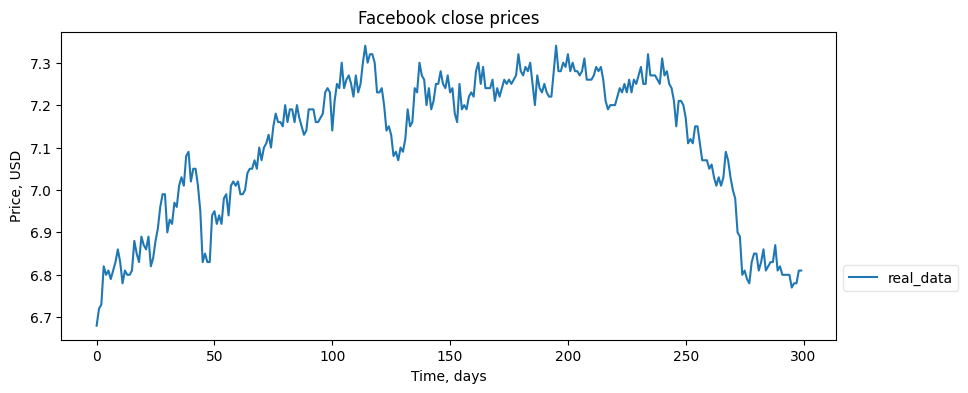

In [2]:
plot_series(stock, "close prices", real_data=stock.real_series[SeriesColumn.CLOSE])

## Predictions parameters

In [3]:
prediction_start = 280
iterations = 5
graph_start = 0

model = PredictionModel(stock, prediction_start, columns, graph_start, iterations=iterations)

## Statistical methods

In [4]:
from normal.stats import AutoArima
from normal.stats import Ces

## ARIMA(p,d,q)

In [5]:
arima = model.configure_model(AutoArima)

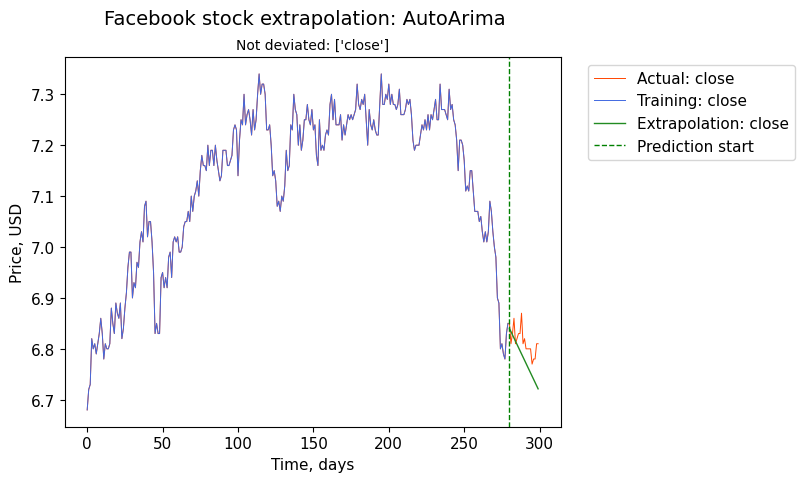

In [6]:
%%capture --no-stdout --no-display
arima.plot_prediction(source=DeviationSource.NONE)

In [7]:
%%capture --no-stdout --no-display
arima.compute_statistics_set()

Statistics [Facebook stock, close prices, 5 iterations]

    Num. Dev. Scale Improve             Time [ms]  Time SD  M. time  RMSE   MAE  MAPE
0      1    -     -       N  1.64 + 101.72 + 0.67     2.26     0.00  0.04  0.04  0.54
1      2    N     S       N  1.63 + 276.65 + 0.67     3.93     0.00  0.03  0.03  0.38
2      3    N     S       Y  1.66 + 347.92 + 0.69     7.20    26.48  0.06  0.05  0.69
3      4    N     M       N   1.63 + 92.96 + 0.65     2.56     0.00  0.02  0.02  0.23
4      5    N     M       Y   1.73 + 78.95 + 0.67     4.55    26.20  0.05  0.04  0.58
5      6    N     H       N   1.75 + 77.27 + 0.69     2.87     0.00  0.05  0.04  0.63
6      7    N     H       Y  1.59 + 248.59 + 0.67     3.12    25.76  0.02  0.02  0.23
7      8    I     S       N   1.66 + 94.90 + 0.64     4.66     0.00  0.04  0.04  0.54
8      9    I     S       Y  1.60 + 261.18 + 0.67    12.05     0.32  0.04  0.03  0.48
9     10    I     M       N   1.74 + 95.80 + 0.63     3.97     0.00  0.05  0.04  0.

## CES

In [8]:
ces = model.configure_model(Ces)

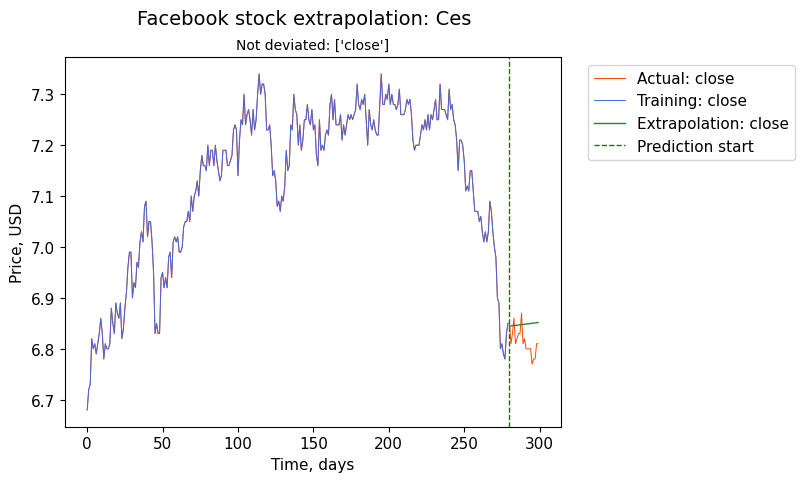

In [9]:
%%capture --no-stdout --no-display
ces.plot_prediction(source=DeviationSource.NONE)

In [10]:
%%capture --no-stdout --no-display
arima.compute_statistics_set()

Statistics [Facebook stock, close prices, 5 iterations]

    Num. Dev. Scale Improve           Time [ms]  Time SD  M. time  RMSE   MAE  MAPE
0      1    -     -       N  1.56 + 6.13 + 0.53     0.22     0.00  0.04  0.04  0.56
1      2    N     S       N  1.47 + 6.07 + 0.50     0.01     0.00  0.04  0.04  0.54
2      3    N     S       Y  1.42 + 9.27 + 0.47     0.08    26.48  0.03  0.03  0.43
3      4    N     M       N  1.42 + 6.58 + 0.47     0.09     0.00  0.04  0.04  0.57
4      5    N     M       Y  1.40 + 7.68 + 0.47     0.15    26.20  0.04  0.03  0.46
5      6    N     H       N  1.37 + 7.14 + 0.46     0.16     0.00  0.05  0.04  0.61
6      7    N     H       Y  1.39 + 5.98 + 0.45     0.19    25.76  0.04  0.04  0.54
7      8    I     S       N  1.36 + 5.69 + 0.45     0.18     0.00  0.04  0.04  0.56
8      9    I     S       Y  1.43 + 5.92 + 0.47     0.06     0.32  0.04  0.04  0.56
9     10    I     M       N  1.41 + 5.38 + 0.49     0.97     0.00  0.05  0.04  0.59
10    11    I     M

## XGBoost

In [11]:
from normal.ml import XGBoost

xgboost = model.configure_model(XGBoost, optimize=False)

C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\utils.py:99: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(series.values[graph_start:], "r", label=f"Actual: {column.value}", linewidth='0.7',
C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\utils.py:108: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(series[graph_start:], "b", label=f"Training: {column.value}", linewidth='0.7',


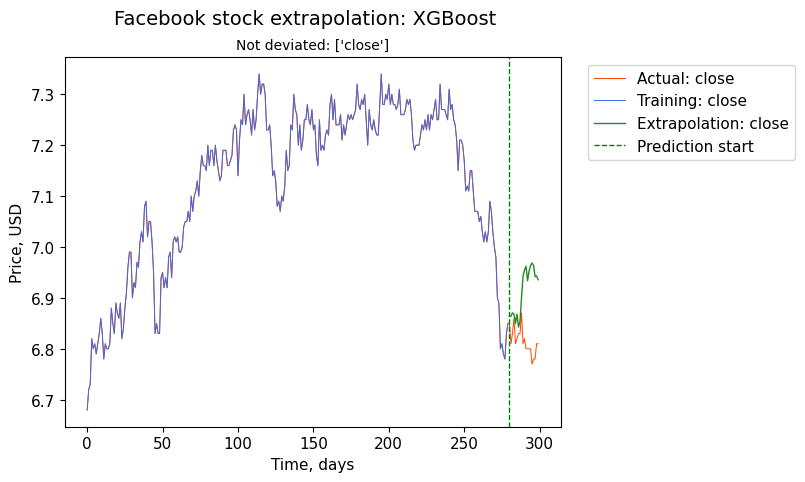

In [12]:
xgboost.plot_prediction(source=DeviationSource.NONE)

In [13]:
%%capture --no-stdout --no-display
xgboost.compute_statistics_set()

Statistics [Facebook stock, close prices, 5 iterations]

    Num. Dev. Scale Improve              Time [ms]  Time SD  M. time  RMSE   MAE  MAPE
0      1    -     -       N  2.90 + 37.52 + 102.05    23.10     0.00  0.12  0.10  1.44
1      2    N     S       N   2.46 + 35.38 + 89.83     4.63     0.00  0.05  0.04  0.56
2      3    N     S       Y   2.32 + 25.95 + 86.29     4.61    26.48  0.04  0.04  0.52
3      4    N     M       N   2.29 + 31.87 + 88.21     6.94     0.00  0.14  0.13  1.92
4      5    N     M       Y   2.33 + 24.95 + 82.97     0.94    26.20  0.04  0.03  0.47
5      6    N     H       N   2.35 + 31.33 + 84.20     1.10     0.00  0.11  0.09  1.26
6      7    N     H       Y   2.47 + 27.98 + 89.62     7.58    25.76  0.04  0.04  0.57
7      8    I     S       N   2.37 + 31.82 + 87.12     3.84     0.00  0.06  0.05  0.71
8      9    I     S       Y   2.45 + 31.55 + 86.89     2.83     0.32  0.12  0.10  1.49
9     10    I     M       N   2.40 + 30.99 + 91.32     4.02     0.00  0.1

## Reservoir computing

In [14]:
from predictions.normal.nn import Reservoir

reservoir = model.configure_model(Reservoir)

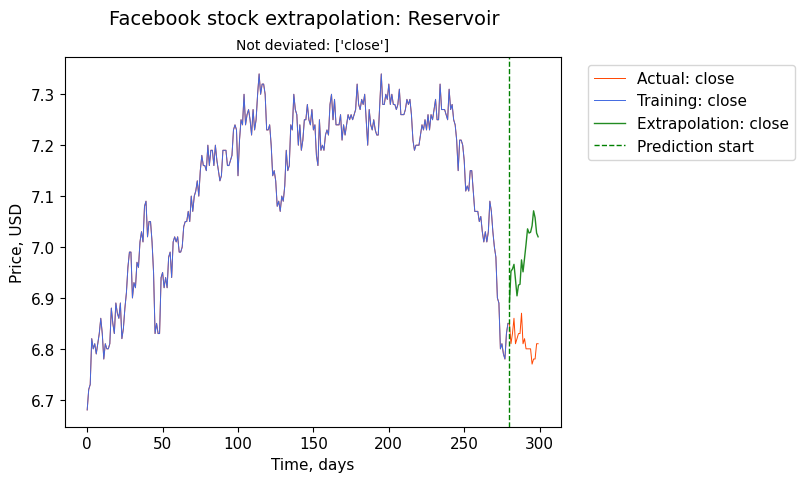

In [15]:
reservoir.plot_prediction(source=DeviationSource.NONE)

In [16]:
%%capture --no-stdout --no-display
reservoir.compute_statistics_set()

Statistics [Facebook stock, close prices, 5 iterations]

    Num. Dev. Scale Improve             Time [ms]  Time SD  M. time  RMSE   MAE  MAPE
0      1    -     -       N  0.24 + 186.61 + 1.39     0.82     0.00  0.18  0.17  2.49
1      2    N     S       N  0.24 + 186.78 + 1.43     2.67     0.00  0.19  0.17  2.53
2      3    N     S       Y  0.26 + 186.59 + 1.47     2.20    26.48  0.10  0.08  1.24
3      4    N     M       N  0.24 + 184.60 + 1.45     1.06     0.00  0.22  0.21  3.08
4      5    N     M       Y  0.24 + 185.54 + 1.41     3.82    26.20  0.10  0.09  1.36
5      6    N     H       N  0.24 + 184.30 + 1.46     2.55     0.00  0.08  0.06  0.86
6      7    N     H       Y  0.24 + 182.34 + 1.40     1.03    25.76  0.03  0.03  0.39
7      8    I     S       N  0.25 + 193.73 + 1.46     1.37     0.00  0.24  0.23  3.42
8      9    I     S       Y  0.25 + 184.37 + 1.43     1.98     0.32  0.21  0.19  2.81
9     10    I     M       N  0.22 + 182.43 + 1.39     1.90     0.00  0.11  0.10  1.